<a href="https://colab.research.google.com/github/pedrolucas-correa/tc2_bird_recognition/blob/main/tc2_reconhecimento_passaros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalação e importação de bibliotecas**

In [ ]:
!pip install tensorflow scikit-learn matplotlib seaborn pandas tqdm --quiet

In [ ]:
import os
import pandas as pd
import shutil
from tqdm import tqdm
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import pickle
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

**Download das imagens**

Necessário salvar o arquivo do dataset no formato **.csv** com as colunas `scientific_name` e `image`

Onde:
* **scientific_name**: Nome dado à classe
* **image**: URL da imagem referente à classe

In [ ]:
df = pd.read_csv("wikiaves.csv")
df.columns = ['scientific_name', 'image']

df['scientific_name'] = df['scientific_name']
df['image'] = df['image']

data_dir = '/content/bird_dataset/'
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.makedirs(data_dir, exist_ok=True)


In [ ]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    specie_dir = os.path.join(data_dir, str(row['scientific_name']).strip().replace(" ", "_").lower())
    os.makedirs(specie_dir, exist_ok=True)

    img_url = row['image']
    fname = os.path.join(specie_dir, f'{row["scientific_name"]}_{idx}.jpg')

    if not os.path.exists(fname):
        try:
            img_data = requests.get(img_url, timeout=10).content
            img = Image.open(BytesIO(img_data)).convert("RGB")
            img = img.resize((128, 128))
            img.save(fname)
        except Exception as e:
            print(f"Erro ao baixar {img_url}: {e}")

**Divisão em treino e validação**

Parte responsável pela divisão das imagens extraídas do dataset em conjuntos de treino e validação

In [ ]:
import glob
from sklearn.model_selection import train_test_split

def train_val_split_images(src_dir, dest_base, val_pct=0.2):
    if os.path.exists(dest_base):
        shutil.rmtree(dest_base)
    for c in os.listdir(src_dir):
        imgs = glob.glob(os.path.join(src_dir, c, '*'))
        if len(imgs) < 2:
            continue
        train_imgs, val_imgs = train_test_split(imgs, test_size=val_pct, random_state=42)
        for split, split_imgs in zip(['train', 'val'], [train_imgs, val_imgs]):
            split_dir = os.path.join(dest_base, split, c)
            os.makedirs(split_dir, exist_ok=True)
            for imgp in split_imgs:
                shutil.copy(imgp, os.path.join(split_dir, os.path.basename(imgp)))

split_base_dir = '/content/bird_split'
train_val_split_images(data_dir, split_base_dir, val_pct=0.2)

train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'val')


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
print('Classes:', train_gen.class_indices)

**Função para selecionar modelo (EfficientNetB0|MobileNetV2)**

In [ ]:
def get_model(base_model_type='EfficientNetB0'):
    if base_model_type == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_type == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    else:
        raise ValueError('Escolha EfficientNetB0 ou MobileNetV2!')
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

**Função para treinar modelo**

In [ ]:
def train_and_evaluate(base_model_type):
    model = get_model(base_model_type)
    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
    ]

    hist = model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=2
    )
    return model, hist

**Treino e armazenamento do EfficientNetB0 e MobileNetV2**

In [ ]:
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Treinando EfficientNetB0
print("Treinando EfficientNetB0...")
model_efficientnet, hist_efficientnet = train_and_evaluate('EfficientNetB0')

# Salvando o modelo EfficientNetB0
efficientnet_path = os.path.join(models_dir, 'efficientnet_b0_model.h5')
model_efficientnet.save(efficientnet_path)
print(f"Modelo EfficientNetB0 salvo em: {efficientnet_path}")

# Treinando MobileNetV2
print("Treinando MobileNetV2...")
model_mobilenet, hist_mobilenet = train_and_evaluate('MobileNetV2')

# Salvando o modelo MobileNetV2
mobilenet_path = os.path.join(models_dir, 'mobilenet_v2_model.h5')
model_mobilenet.save(mobilenet_path)
print(f"Modelo MobileNetV2 salvo em: {mobilenet_path}")

# Salvar apenas os pesos
weights_dir = os.path.join(models_dir, 'weights')
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

model_efficientnet.save_weights(os.path.join(weights_dir, 'efficientnet_b0.weights.h5'))
model_mobilenet.save_weights(os.path.join(weights_dir, 'mobilenet_v2.weights.h5'))

print("Treinamento completo e modelos salvos com sucesso!")


**Criação dos gráficos de curva de aprendizado/validação e comparação dos modelos (Acurácia e Loss)**

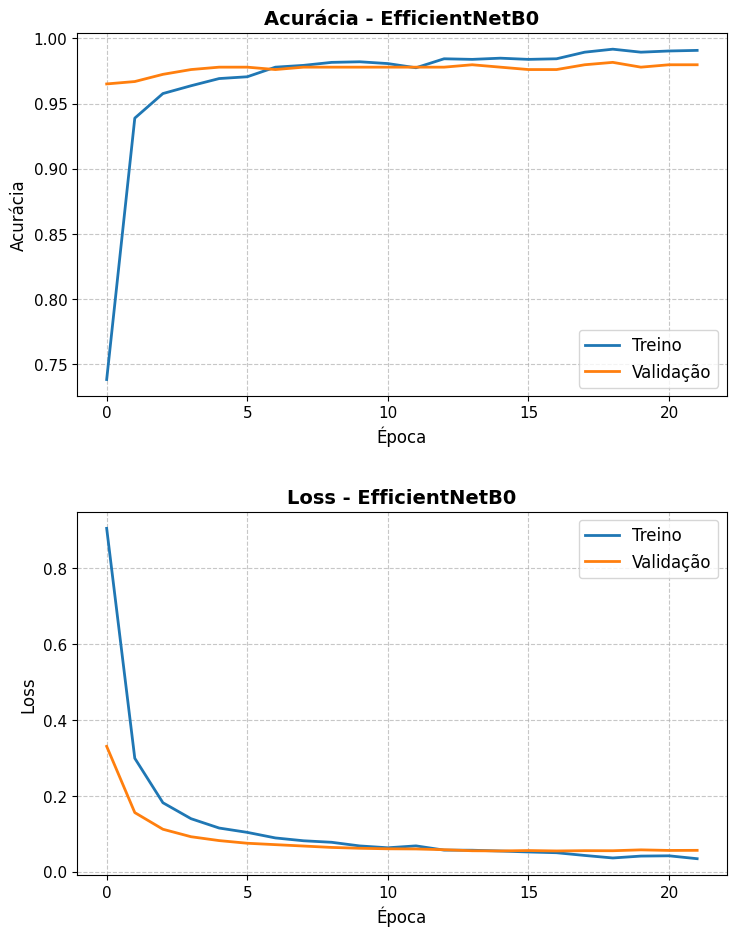

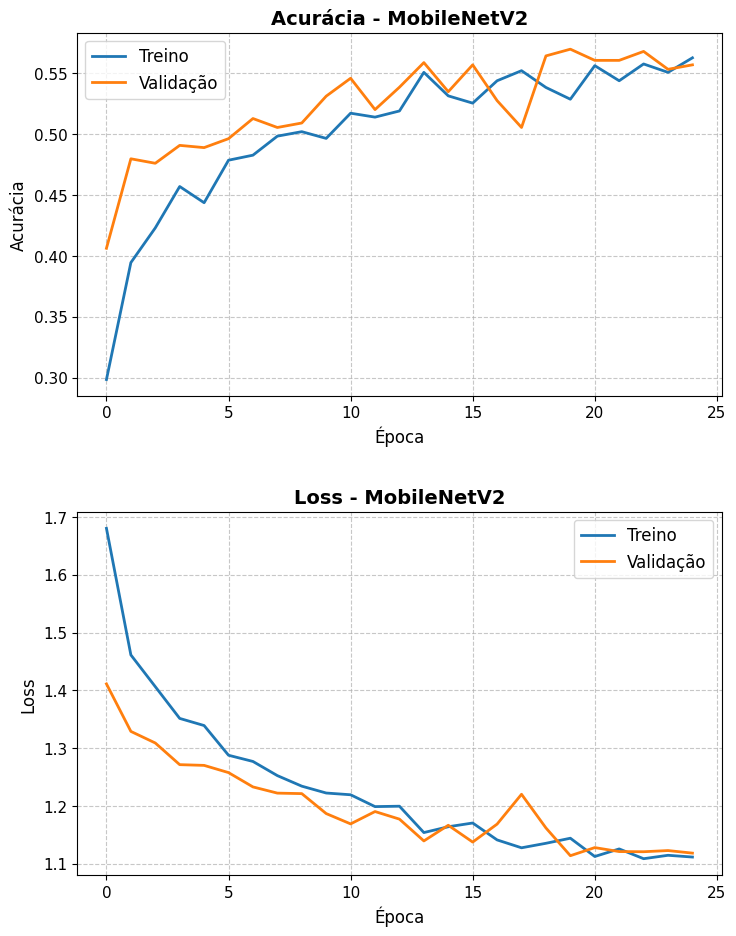

In [ ]:
def plot_history_vertical(hist, title):
    plt.figure(figsize=(8, 10))

    # Gráfico de Acurácia (superior)
    plt.subplot(2, 1, 1)
    plt.plot(hist.history['accuracy'], label='Treino', linewidth=2)
    plt.plot(hist.history['val_accuracy'], label='Validação', linewidth=2)
    plt.title(f'Acurácia - {title}', fontsize=14, fontweight='bold')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=11)

    # Gráfico de Loss (inferior)
    plt.subplot(2, 1, 2)
    plt.plot(hist.history['loss'], label='Treino', linewidth=2)
    plt.plot(hist.history['val_loss'], label='Validação', linewidth=2)
    plt.title(f'Loss - {title}', fontsize=14, fontweight='bold')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(pad=3.0)
    plt.savefig(f'curva_aprendizado_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_comparison_vertical(hist1, name1, hist2, name2):
    plt.figure(figsize=(8, 12))

    # Gráfico de Acurácia (superior)
    plt.subplot(2, 1, 1)
    plt.plot(hist1.history['accuracy'], label=f'Treino {name1}', linewidth=2)
    plt.plot(hist1.history['val_accuracy'], label=f'Validação {name1}', linewidth=2, linestyle='--')
    plt.plot(hist2.history['accuracy'], label=f'Treino {name2}', linewidth=2)
    plt.plot(hist2.history['val_accuracy'], label=f'Validação {name2}', linewidth=2, linestyle='--')
    plt.title('Comparação de Acurácia', fontsize=14, fontweight='bold')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11, loc='lower right')
    plt.tick_params(axis='both', which='major', labelsize=11)

    # Gráfico de Loss (inferior)
    plt.subplot(2, 1, 2)
    plt.plot(hist1.history['loss'], label=f'Treino {name1}', linewidth=2)
    plt.plot(hist1.history['val_loss'], label=f'Validação {name1}', linewidth=2, linestyle='--')
    plt.plot(hist2.history['loss'], label=f'Treino {name2}', linewidth=2)
    plt.plot(hist2.history['val_loss'], label=f'Validação {name2}', linewidth=2, linestyle='--')
    plt.title('Comparação de Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11, loc='upper right')
    plt.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(pad=3.0)
    plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_history_vertical(hist_efficientnet, 'EfficientNetB0')
plot_history_vertical(hist_mobilenet, 'MobileNetV2')

# plot_comparison_vertical(hist_efficientnet, 'EfficientNetB0', hist_mobilenet, 'MobileNetV2')

**Métricas e matrizes de confusão**

34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
--- Relatório para EfficientNetB0 ---
                          precision    recall  f1-score   support

herpetotheres_cachinnans       0.96      0.98      0.97       112
    phylloscartes_kronei       0.97      0.97      0.97        92
selenidera_maculirostris       0.99      0.98      0.99       152
    tangara_cyanocephala       1.00      0.99      0.99        96
 trichothraupis_melanops       0.95      0.96      0.95        92

                accuracy                           0.98       544
               macro avg       0.97      0.98      0.97       544
            weighted avg       0.98      0.98      0.98       544



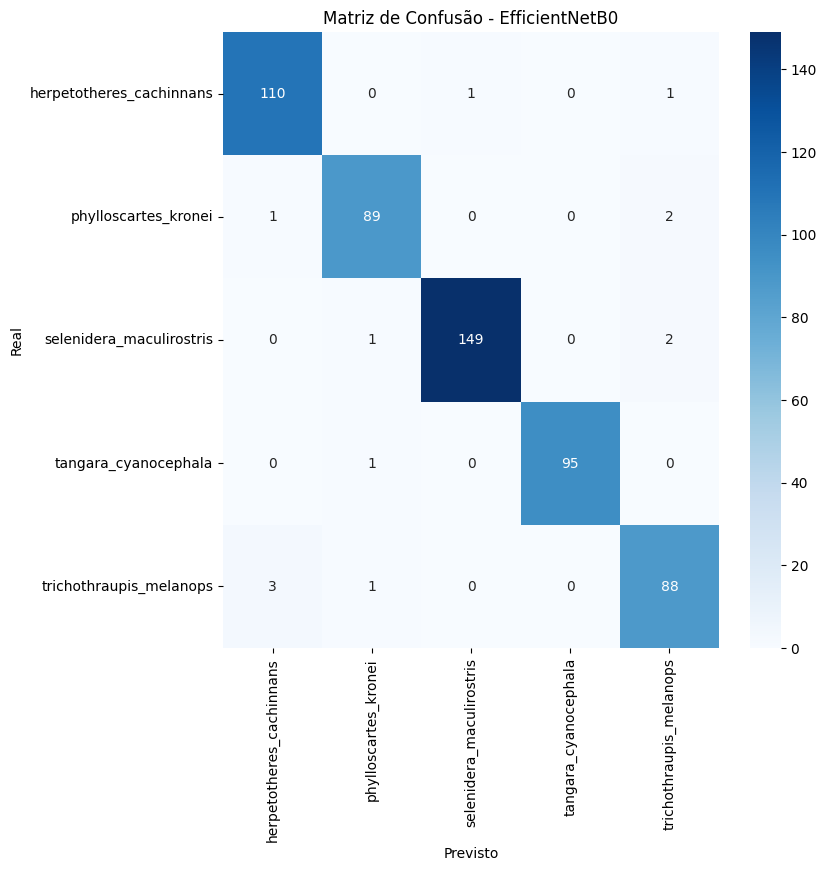

Acurácia: 97.61%
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step
--- Relatório para MobileNetV2 ---
                          precision    recall  f1-score   support

herpetotheres_cachinnans       0.86      0.69      0.76       112
    phylloscartes_kronei       0.62      0.33      0.43        92
selenidera_maculirostris       0.45      0.87      0.59       152
    tangara_cyanocephala       0.64      0.46      0.53        96
 trichothraupis_melanops       0.66      0.29      0.41        92

                accuracy                           0.57       544
               macro avg       0.64      0.53      0.54       544
            weighted avg       0.63      0.57      0.56       544



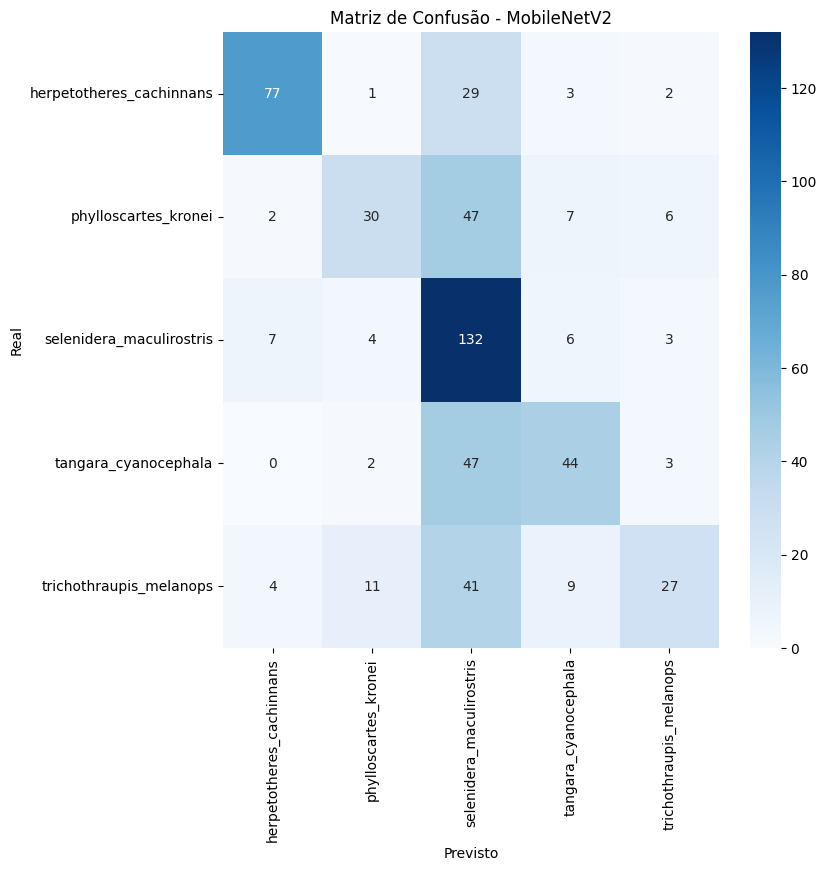

Acurácia: 56.99%


In [ ]:
def evaluate_model(model, val_gen, class_names, model_name):
    Y_pred = model.predict(val_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_gen.classes

    print(f'--- Relatório para {model_name} ---')
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

    acc = np.sum(y_pred==y_true)/len(y_true)
    print(f'Acurácia: {acc*100:.2f}%')

evaluate_model(model_efficientnet, val_gen, list(val_gen.class_indices.keys()), 'EfficientNetB0')
evaluate_model(model_mobilenet, val_gen, list(val_gen.class_indices.keys()), 'MobileNetV2')


**Função para teste dos modelos salvos**

In [ ]:
def test_on_single_image(model, image_path, class_names, model_type='EfficientNetB0'):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    if model_type == 'EfficientNetB0':
        from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
        img_array = efficientnet_preprocess(img_array)
    elif model_type == 'MobileNetV2':
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
        img_array = mobilenet_preprocess(img_array)
    else:
        img_array = img_array / 255.0

    start_time = time.time()
    prediction = model.predict(img_array, verbose=0)
    end_time = time.time()
    time_taken = end_time - start_time

    print("\nClass probabilities:")
    for i, (cls, prob) in enumerate(zip(class_names, prediction[0])):
        print(f"{i}. {cls}: {prob:.4f}")

    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    print(f"\nTime taken to recognize: {time_taken:.4f} seconds")

    plt.figure(figsize=(6, 6))
    plt.imshow(image.load_img(image_path, target_size=(224, 224)))
    plt.title(f'Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

**Teste em imagem única**

Necessário salvar imagem do teste no diretório `./test_images/`

Retorna resultado da predição, confiança e tempo levado de cada modelo.


Testing EfficientNetB0 on sample image:

Class probabilities:
0. herpetotheres_cachinnans: 0.9947
1. phylloscartes_kronei: 0.0018
2. selenidera_maculirostris: 0.0015
3. tangara_cyanocephala: 0.0002
4. trichothraupis_melanops: 0.0018

Time taken to recognize: 0.2402 seconds


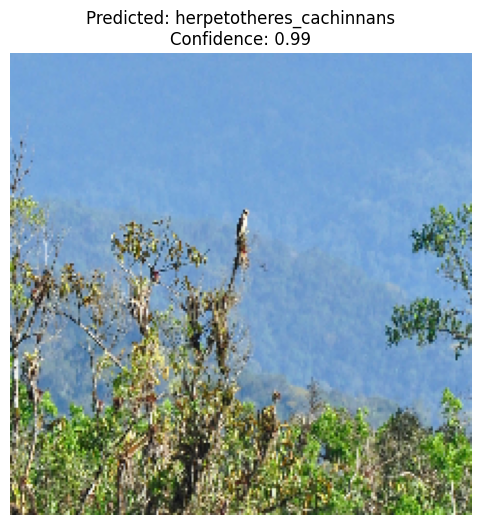


Testing MobileNetV2 on sample image:

Class probabilities:
0. herpetotheres_cachinnans: 0.9948
1. phylloscartes_kronei: 0.0020
2. selenidera_maculirostris: 0.0013
3. tangara_cyanocephala: 0.0008
4. trichothraupis_melanops: 0.0011

Time taken to recognize: 0.2630 seconds


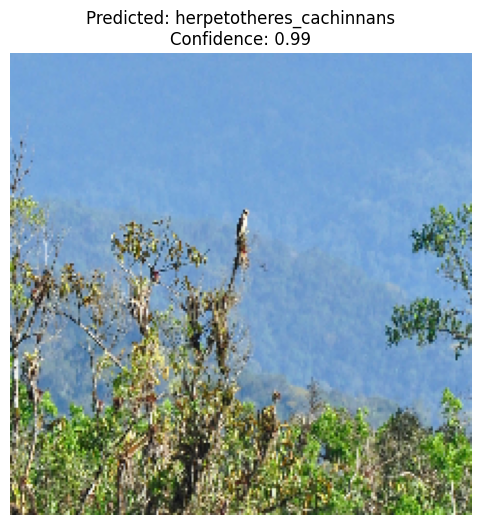

In [ ]:

from tensorflow.keras.preprocessing import image

class_names = list(val_gen.class_indices.keys())

test_image_path = './test_images/acaua.jpg'

if os.path.exists(test_image_path):
    print("\nTesting EfficientNetB0 on sample image:")
    predicted_class, confidence = test_on_single_image(model_efficientnet,
                                                     test_image_path,
                                                     class_names,
                                                     model_type='EfficientNetB0')

    print("\nTesting MobileNetV2 on sample image:")
    predicted_class, confidence = test_on_single_image(model_mobilenet,
                                                    test_image_path,
                                                    class_names,
                                                    model_type='MobileNetV2')